In [1]:
import sys
sys.path.insert(0, '/home/hyeuk/Projects/BNS_JT')

In [2]:
import networkx as nx
import numpy as np
from pathlib import Path
import copy

from BNS_JT import trans, branch, variable, cpm, gen_bnb

HOME = Path.cwd()

In [3]:
import pandas as pd

# Illustrative example: Routine

In [4]:
# Network
node_coords = {'n1': (0, 0),
               'n2': (1, 1),
               'n3': (1, -1),
               'n4': (2, 0)}

arcs = {'e1': ['n1', 'n2'],
	'e2': ['n1', 'n3'],
	'e3': ['n2', 'n3'],
	'e4': ['n2', 'n4'],
	'e5': ['n3', 'n4']}
n_arc = len(arcs)

probs = {'e1': {0: 0.01, 1:0.99}, 'e2': {0:0.02, 1:0.98}, 'e3': {0:0.03, 1:0.97}, 'e4': {0:0.04, 1:0.96}, 'e5': {0:0.05, 1:0.95}}

od_pair=('n1','n4')


In [5]:
nodes = pd.DataFrame(node_coords, index=['pos_x', 'pos_y']).T

In [6]:
from BNS_JT import config

In [7]:
cfg = config.Config('/home/hyeuk/Projects/BNS_JT/BNS_JT/demos/routine/config.json')

scenario to be added later


In [10]:
cfg.infra['ODs']

{'od1': ('n1', 'n4')}

In [23]:
nodes

,pos_x,pos_y
n1,0,0
n2,1,1
n3,1,-1
n4,2,0


In [8]:
def conn(comps_st, od_pair, arcs): # connectivity analysis
    G = nx.Graph()
    for k,x in comps_st.items():
        if x > 0:
            G.add_edge(arcs[k][0], arcs[k][1], capacity=1)


    if od_pair[0] in G.nodes and od_pair[1] in G.nodes:
        f_val, _ = nx.maximum_flow(G,od_pair[0],od_pair[1])
    else:
        f_val = 0

    if f_val > 0:
        sys_st = 's'

        p = nx.shortest_path( G, od_pair[0], od_pair[1] )

        min_comps_st = {}
        for i in range(len(p)-1):
            pair = [p[i], p[i+1]]
            if pair in arcs.values():
                a = list(arcs.keys())[list(arcs.values()).index(pair)]
            else:
                a = list(arcs.keys())[list(arcs.values()).index([pair[1], pair[0]])]
            min_comps_st[a] = 1

    else:
        sys_st = 'f'
        min_comps_st = None

    return f_val, sys_st, min_comps_st

sys_fun = lambda comps_st : conn(comps_st, od_pair, arcs)

In [9]:
comps_st1 = {'e'+str(i+1): 1 for i in range(n_arc)}
f_val1, sys_st1, min_comps_st1 = conn(comps_st1, od_pair, arcs)
print( f_val1, sys_st1, min_comps_st1 )

comps_st2 = {'e1':1, 'e2': 0, 'e3':0, 'e4':0, 'e5':1}
f_val2, sys_st2, min_comps_st2 = conn(comps_st2, od_pair, arcs)
print( f_val2, sys_st2, min_comps_st2 )

2 s {'e1': 1, 'e4': 1}
0 f None


In [10]:
varis = {}
for k, v in arcs.items():
    varis[k] = variable.Variable( name=k, values = ['fail', 'surv'])

In [11]:
brs, rules, sys_res, monitor = gen_bnb.proposed_branch_and_bound_using_probs(sys_fun, varis, probs, max_br=1000,
                                                        output_path=HOME, key='conn')


[System function runs 0]..
The # of found non-dominated rules (f, s): 0 (0, 0)
Probability of branchs (f, s, u): (0.00, 0.00, 1.00)
# of unknown branches to go: 1, 1

[System function runs 1]..
The # of found non-dominated rules (f, s): 1 (0, 1)
Probability of branchs (f, s, u): (0.00, 0.00, 1.00)
# of unknown branches to go: 1, 1

[System function runs 2]..
The # of found non-dominated rules (f, s): 2 (1, 1)
Probability of branchs (f, s, u): (0.00, 0.00, 1.00)
# of unknown branches to go: 2, 2

[System function runs 2]..
The # of found non-dominated rules (f, s): 2 (1, 1)
Probability of branchs (f, s, u): (0.00, 0.00, 1.00)
# of unknown branches to go: 1, 2

[System function runs 3]..
The # of found non-dominated rules (f, s): 2 (1, 1)
Probability of branchs (f, s, u): (0.00, 0.00, 1.00)
# of unknown branches to go: 2, 2

[System function runs 3]..
The # of found non-dominated rules (f, s): 2 (1, 1)
Probability of branchs (f, s, u): (0.00, 0.00, 1.00)
# of unknown branches to go: 1, 2

# 1. Plotting of Branch and Bound results

In [15]:
import matplotlib.pyplot as plt

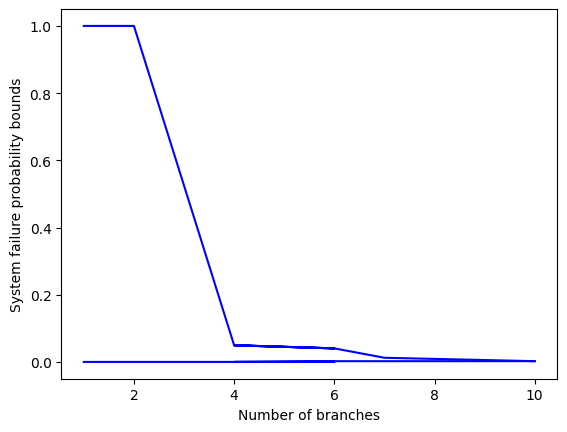

In [22]:
plt.plot(br_ns, pf_low, color='blue')
plt.plot(br_ns, pf_up, color='blue')
plt.xlabel('Number of branches')
plt.ylabel('System failure probability bounds')

%matplotlib inline
plt.show()

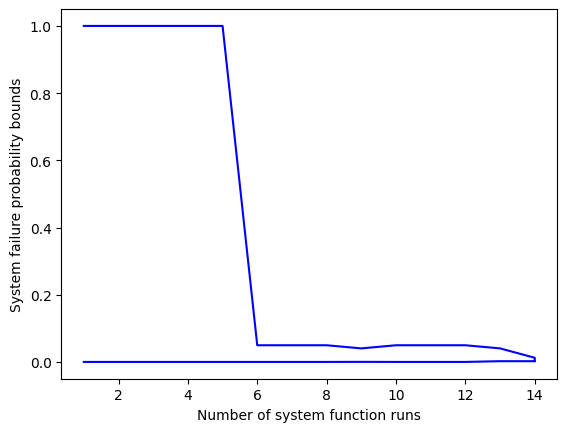

In [23]:
plt.plot(sf_ns, pf_low, color='blue')
plt.plot(sf_ns, pf_up, color='blue')
plt.xlabel('Number of system function runs')
plt.ylabel('System failure probability bounds')

%matplotlib inline
plt.show()

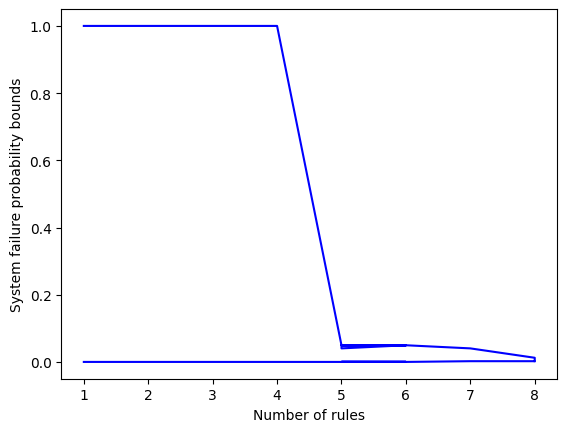

In [24]:
plt.plot(r_ns, pf_low, color='blue')
plt.plot(r_ns, pf_up, color='blue')
plt.xlabel('Number of rules')
plt.ylabel('System failure probability bounds')

%matplotlib inline
plt.show()

# 2. Inference -- New product function to not split composite states in a system event's C matrix

In [12]:
st_br_to_cs = {'f': 0, 's': 1, 'u': 2}
result = gen_bnb.get_csys_from_brs(brs, varis, st_br_to_cs)

In [13]:
cpms = {}
for e,v in arcs.items():
    cpms[e] = cpm.Cpm( variables=[varis[e]], no_child = 1, C=np.array([0,1]), p=[probs[e][0], probs[e][1]] )


In [14]:
varis['sys'] = variable.Variable( name='sys', values=['f', 's', 'u'] ) #FIXME When trying to define B here, an error occurs. Can we revise this to give users liberty to define this?
cpms['sys'] = cpm.Cpm( variables=[varis['sys']] + [varis[e] for e in arcs.keys()], no_child = 1, C=result[0], p=np.ones((len(result[0]),1)) )


In [15]:
# New product function
def prod_Msys_Mcomps(Msys, Mcomps_dict, varis):
    Cs = Msys.C
    ps = Msys.p
    v_sys = Msys.variables

    p_new = copy.deepcopy(ps)
    for i in range(len(v_sys)-Msys.no_child):
        c_name = v_sys[Msys.no_child+i].name
        M1 = Mcomps_dict[c_name]
        C1_list = [c[0] for c in M1.C] # TODO: For now this only works for marginal distributions of component evets
        for j in range(len(p_new)):
            st = Cs[j][Msys.no_child+i]
            st_set = varis[c_name].B[st]
            p_st = 0.0
            for k in st_set:
                p_st += M1.p[C1_list.index(k)][0]

            p_new[j] *= p_st

    Mnew = cpm.Cpm( variables=v_sys, no_child=len(v_sys), C = Cs, p = p_new )

    return Mnew

In [16]:
Msys = copy.deepcopy( cpms['sys'] )
Mcomps = copy.deepcopy( {x:cpms[x] for x in arcs.keys()} )

Mnew = prod_Msys_Mcomps(Msys, Mcomps, varis)
print(Mnew)

Cpm(variables=['sys', 'e1', 'e2', 'e3', 'e4', 'e5'], no_child=6, C=[[1 1 2 2 1 2]
 [1 1 1 2 0 1]
 [1 0 1 2 2 1]
 [0 1 2 2 0 0]
 [0 1 0 0 0 1]
 [1 1 0 1 0 1]
 [0 0 1 1 0 0]
 [1 0 1 1 1 0]
 [0 0 0 2 2 2]
 [0 0 1 0 2 0]], p=[[9.50400e-01]
 [3.68676e-02]
 [9.31000e-03]
 [1.98000e-03]
 [2.25720e-05]
 [7.29828e-04]
 [1.90120e-05]
 [4.56288e-04]
 [2.00000e-04]
 [1.47000e-05]]


In [17]:
Mnew1 = cpm.prod_cpm_sys_and_comps(Msys, Mcomps, varis)

In [19]:
Msys

Cpm(variables=['sys', 'e1', 'e2', 'e3', 'e4', 'e5'], no_child=1, C=[[1 1 2 2 1 2]
 [1 1 1 2 0 1]
 [1 0 1 2 2 1]
 [0 1 2 2 0 0]
 [0 1 0 0 0 1]
 [1 1 0 1 0 1]
 [0 0 1 1 0 0]
 [1 0 1 1 1 0]
 [0 0 0 2 2 2]
 [0 0 1 0 2 0]], p=[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]

In [18]:
Mnew1

Cpm(variables=['sys', 'e1', 'e2', 'e3', 'e4', 'e5'], no_child=6, C=[[1 1 2 2 1 2]
 [1 1 1 2 0 1]
 [1 0 1 2 2 1]
 [0 1 2 2 0 0]
 [0 1 0 0 0 1]
 [1 1 0 1 0 1]
 [0 0 1 1 0 0]
 [1 0 1 1 1 0]
 [0 0 0 2 2 2]
 [0 0 1 0 2 0]], p=[[9.50400e-01]
 [3.68676e-02]
 [9.31000e-03]
 [1.98000e-03]
 [2.25720e-05]
 [7.29828e-04]
 [1.90120e-05]
 [4.56288e-04]
 [2.00000e-04]
 [1.47000e-05]]

In [78]:
def get_prob( M, v_name, v_st ):

    v_names = [v.name for v in M.variables]
    v_loc = v_names.index(v_name)

    C_list = [c[v_loc] for c in M.C]
    prob = 0.0
    for i,c in enumerate(C_list):
        if c == v_st:
            prob += M.p[i]

    return prob
    


In [80]:
pf = get_prob( Mnew, 'sys', 0 )
print("failure prob: ", pf)

ps = get_prob( Mnew, 'sys', 1 )
print("survival prob: ", ps)



failure prob:  [0.00223628]
survival prob:  [0.99776372]


# 3. B&B + MCS

In [ ]:
varis_c = {e:varis[e] for e in arcs.keys()}

# Incomplete B&B (by setting max_br=10)
brs2, rules2, sys_res2, _, _, _, _, _ = gen_bnb.proposed_branch_and_bound_using_probs(sys_fun, varis_c, probs, max_br=8,
                                                                                      output_path=HOME, key='conn')

st_br_to_cs = {'f': 0, 's': 1, 'u': 2}
result2 = gen_bnb.get_csys_from_brs(brs2, varis_c, st_br_to_cs)

varis['sys2'] = variable.Variable( name='sys2', values=['f', 's', 'u'] ) #FIXME When trying to define B here, an error occurs. Can we revise this to give users liberty to define this?
cpms['sys2'] = cpm.Cpm( variables=[varis['sys2']] + [varis[e] for e in arcs.keys()], no_child = 1, C=result2[0], p=np.ones((len(result2[0]),1)) )

In [89]:
print(cpms['sys2'])

Cpm(variables=['sys2', 'e1', 'e2', 'e3', 'e4', 'e5'], no_child=1, C=[[1 1 2 2 1 2]
 [2 1 0 2 0 1]
 [1 1 1 2 0 1]
 [1 0 1 2 2 1]
 [0 1 2 2 0 0]
 [0 0 1 0 2 0]
 [2 0 1 1 2 0]
 [0 0 0 2 2 2]], p=[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [97]:
def get_Msub( M, v_name, v_st ):

    v_names = [v.name for v in M.variables]
    v_loc = v_names.index(v_name)

    Csub = np.empty((0,len(v_names)), dtype=int)
    psub = np.empty((0,1), dtype=float)

    C_list = [c[v_loc] for c in M.C]
    for i,c in enumerate(C_list):
        if c == v_st:
            Csub=np.vstack([Csub, M.C[i]])
            psub =np.vstack([psub, M.p[i]])

    Msub = cpm.Cpm( variables=M.variables, no_child=M.no_child, C=Csub, p=psub )

    return Msub

In [98]:
Msys2 = copy.deepcopy( cpms['sys2'] )
Mnew2 = prod_Msys_Mcomps(Msys2, Mcomps, varis)

pf2_bnb = get_prob( Mnew2, 'sys2', 0 )
print(pf2_bnb)

unk_pr = get_prob( Mnew2, 'sys2', 2 )
print(unk_pr)

Munk = get_Msub( Mnew2, 'sys2', 2 )
print(Munk)

Cpm(variables=['sys2', 'e1', 'e2', 'e3', 'e4', 'e5'], no_child=6, C=[[1 1 2 2 1 2]
 [2 1 0 2 0 1]
 [1 1 1 2 0 1]
 [1 0 1 2 2 1]
 [0 1 2 2 0 0]
 [0 0 1 0 2 0]
 [2 0 1 1 2 0]
 [0 0 0 2 2 2]], p=[[9.50400e-01]
 [7.52400e-04]
 [3.68676e-02]
 [9.31000e-03]
 [1.98000e-03]
 [1.47000e-05]
 [4.75300e-04]
 [2.00000e-04]]
[0.0021947]
[0.0012277]
Cpm(variables=['sys2', 'e1', 'e2', 'e3', 'e4', 'e5'], no_child=6, C=[[2 1 0 2 0 1]
 [2 0 1 1 2 0]], p=[[0.0007524]
 [0.0004753]]


In [ ]:
cov = 1.0
cov_t = 0.05
no_pf_mcs = 0
no_mcs = 0
while (cov > cov_t) or (no_pf_mcs < 1):

    no_mcs += 1
    

In [113]:
import random
Mmcs = Munk
c_names = list(arcs.keys())

In [112]:
samp_ind = random.choices( list(range(len(Mmcs.p))), weights=(k[0] for k in Mmcs.p) )
print(samp_ind)


v_names = [v.name for v in Mmcs.variables]
c_locs = {c:v_names.index(c) for c in c_names}

samp_e = Mmcs.C[samp_ind]
samp = np.empty((0,len(1+c_names)), dtype=int)
for c in c_names:
    c_st = samp_e[c_locs[c]]
    c_B = varis[c].B

    if len(c_B) < 2:
        samp[c_locs[c]] = c_B[0]
    else:
        ##############290224

[1]
